# Ансамбли моделей машинного обучения.

### Импорт библиотек

In [248]:
import numpy as np
import pandas as pd
from io import StringIO 
from pmdarima import auto_arima
import pmdarima as pm
from IPython.display import Image
from heamy.dataset import Dataset
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline
from statsmodels.tsa.arima.model import ARIMA
from gmdhpy import gmdh
import pydotplus
import seaborn as sns
import xgboost as xgb
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.svm import SVR
import operator
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.datasets import *
sns.set(style="ticks")

In [2]:
df = pd.read_csv('OPEC-ORB.csv', header=0, index_col=0, parse_dates=True)

In [3]:
df

,Value
Date,
2022-06-10,123.19
2022-06-09,123.21
2022-06-08,121.54
2022-06-07,120.16
2022-06-06,119.85
...,...
2003-01-08,28.86
2003-01-07,29.72
2003-01-06,30.71


In [4]:
# рассмотрим данные только за последние три года
df = df[:720]

### Визуализация ряда

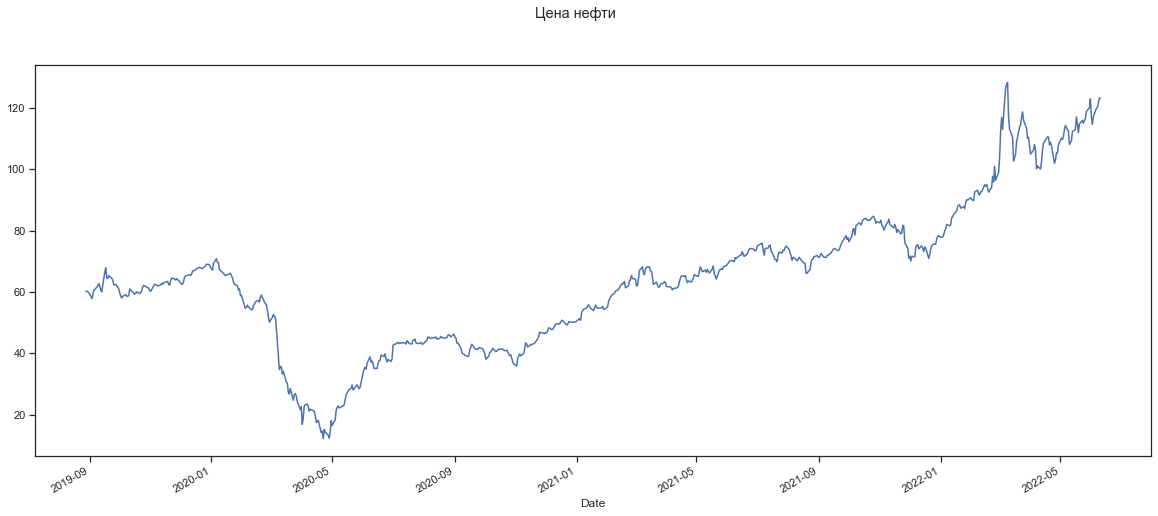

In [5]:
fig, ax = plt.subplots(figsize=(20,8))
fig.suptitle('Цена нефти')
df.plot(ax=ax, legend=False)
plt.show()

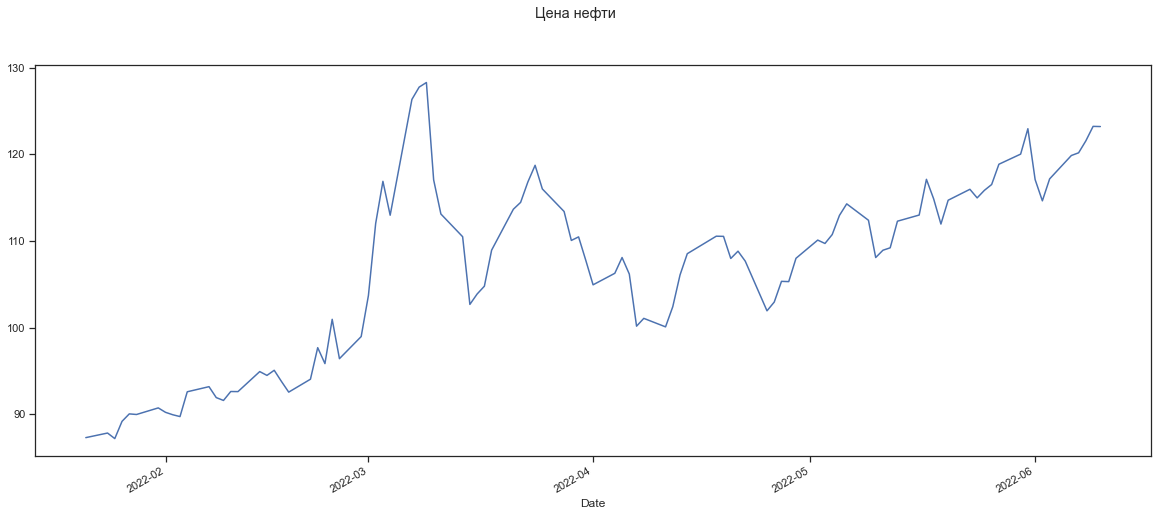

In [6]:
# Первые 100 точек
fig, ax = plt.subplots(figsize=(20,8))
fig.suptitle('Цена нефти')
df[:100].plot(ax=ax, legend=False)
plt.show()

Вероятность распределения данных

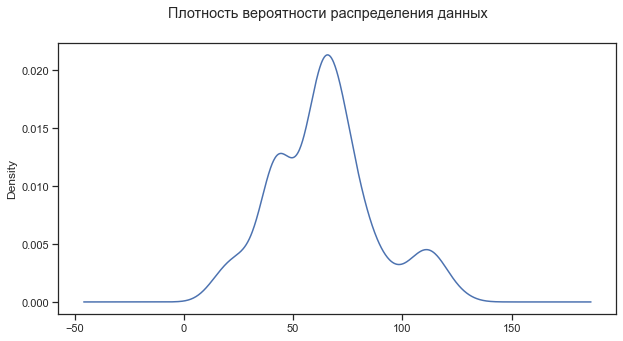

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle('Плотность вероятности распределения данных')
df.plot(ax=ax, kind='kde', legend=False)
plt.show()

#### Лаги 4 порядков

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


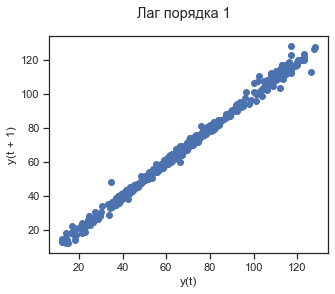

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


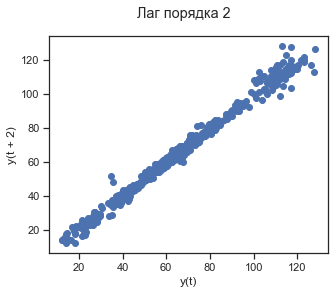

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


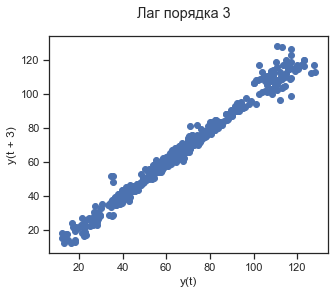

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


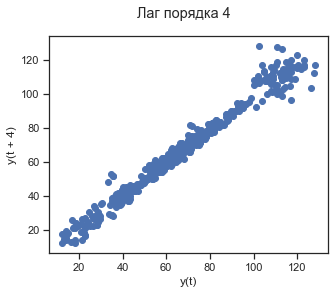

In [8]:
for i in range(1, 5):
    fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(5,4))
    fig.suptitle(f'Лаг порядка {i}')
    pd.plotting.lag_plot(df, lag=i, ax=ax)
    plt.show()

#### Автокорелляционная диаграммы

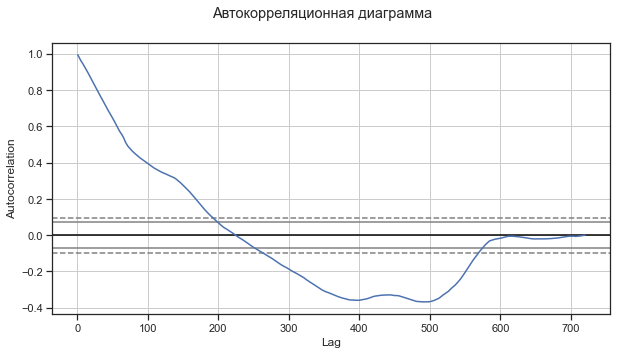

In [9]:
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Автокорреляционная диаграмма')
pd.plotting.autocorrelation_plot(df, ax=ax)
plt.show()

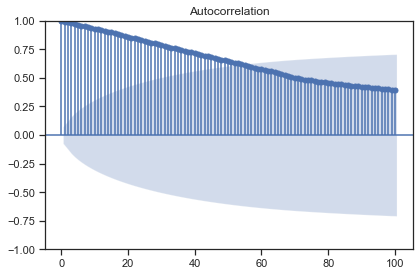

In [10]:
plot_acf(df, lags=100)
plt.tight_layout()

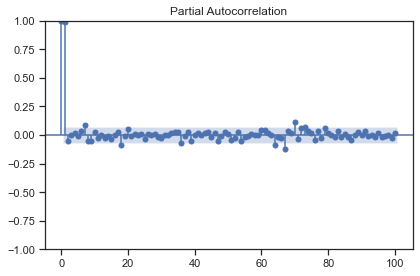

In [11]:
plot_pacf(df, lags=100, method='ywm')
plt.tight_layout()

#### Декомпозиция ряда

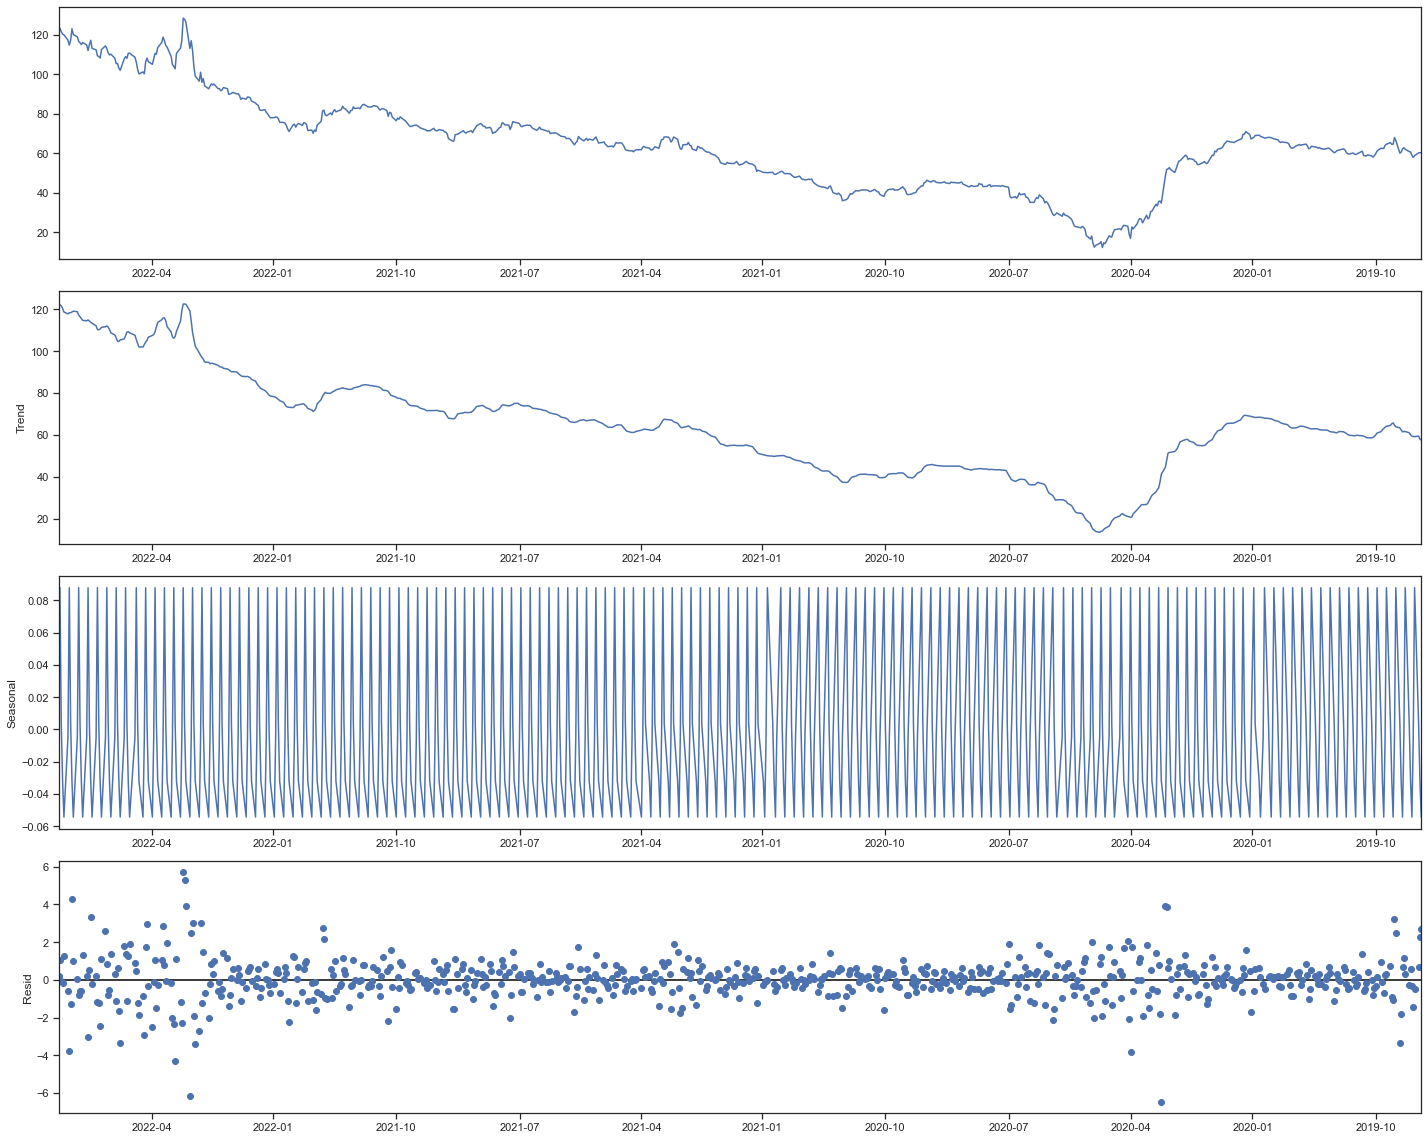

In [12]:
result_add = seasonal_decompose(df, model = 'add', extrapolate_trend='freq', period=5)
fg = result_add.plot()
fg.set_size_inches((20, 16))
# Перерисовка
fg.tight_layout()
plt.show()

#### Скользящее среднее

In [13]:
df_mean = df.copy()

In [14]:
df_mean['SMA_20'] = df_mean['Value'].rolling(20, min_periods=1).mean()
df_mean['SMA_60'] = df_mean['Value'].rolling(60, min_periods=1).mean()
df_mean['SMA_5'] = df_mean['Value'].rolling(5, min_periods=1).mean()

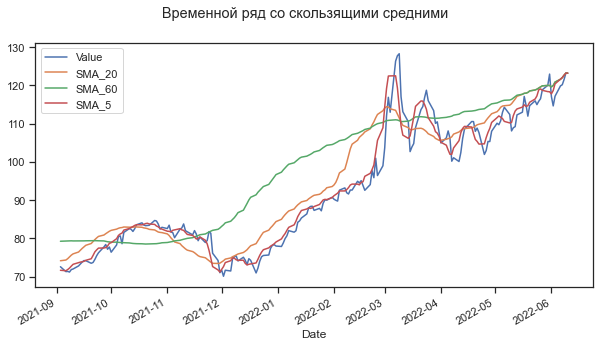

In [15]:
fig, ax = plt.subplots(sharey='row', figsize=(10,5))
fig.suptitle('Временной ряд со скользящими средними')
df_mean[:200].plot(ax=ax, legend=True)
plt.show()

### Метод ARIMA

Подготовка данных, разделение на тестовую и тренеровочную выборки

In [16]:
arima_order = (5,1,5)
df_sort = df.sort_index()
# Целочисленная метка шкалы времени 
xnum = list(range(df_sort.shape[0]))
# Разделение выборки на обучающую и тестовую
Y = df_sort['Value'].values
train_size = int(len(Y) * 0.8)
xnum_train, xnum_test = xnum[0:train_size], xnum[train_size:]
train, test = Y[0:train_size], Y[train_size:]
train

array([60.16, 60.24, 60.11, 58.76, 57.81, 58.97, 60.58, 60.75, 62.  ,
       62.74, 62.08, 60.51, 60.02, 66.43, 67.88, 64.57, 64.39, 65.3 ,
       64.51, 63.93, 62.35, 62.31, 62.51, 61.09, 59.68, 58.75, 57.99,
       58.62, 59.12, 58.56, 58.68, 58.74, 60.97, 59.95, 59.62, 59.28,
       59.54, 60.06, 59.5 , 59.78, 60.42, 61.63, 62.16, 61.65, 61.44,
       61.24, 60.52, 60.19, 62.  , 62.57, 62.39, 62.32, 61.98, 62.26,
       62.82, 62.48, 63.  , 63.12, 63.44, 62.51, 62.22, 63.68, 64.56,
       64.21, 63.92, 64.4 , 63.94, 63.83, 62.5 , 62.57, 63.39, 64.81,
       65.24, 65.57, 65.66, 65.38, 65.81, 66.76, 67.22, 67.48, 67.77,
       67.93, 68.  , 67.58, 67.99, 68.48, 69.07, 68.89, 67.96, 67.12,
       69.38, 70.87, 69.6 , 69.58, 67.24, 67.02, 66.07, 65.63, 65.32,
       65.62, 65.58, 66.11, 65.26, 64.66, 63.26, 62.52, 61.98, 60.67,
       61.04, 58.8 , 58.94, 55.53, 54.68, 55.01, 55.74, 55.13, 54.21,
       54.2 , 55.59, 55.9 , 56.77, 57.28, 56.72, 58.39, 58.98, 58.21,
       56.14, 55.91,

In [204]:
history_base_arima = [x for x in train]

# Формирование предсказаний на основе простого метода ARIMA
predictions_base_arima = list()
for t in range(len(test)):
    model_arima = ARIMA(history_base_arima, order=arima_order)
    model_arima_fit = model_arima.fit(method_kwargs={'warn_convergence':False})
    yhat_arima = model_arima_fit.forecast()[0]
    predictions_base_arima.append(yhat_arima)
    history_base_arima.append(test[t])

D:\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [221]:
history_auto_arima = [x for x in train]

# Формирование предсказаний на основе метода ARIMA с автоподбором гипперпараметров
predictions_auto_arima = list()
for t in range(len(test)):
    model_arima = pm.auto_arima(history_auto_arima, suppress_warnings=True, error_action='trace')
    yhat_arima = model_arima.predict(n_periods=1)
    predictions_auto_arima.append(yhat_arima[0])
    history_auto_arima.append(test[t])

### Рекуретная нейроная сесть

Опишем некоторые константы

In [224]:
SEQ_SIZE = 240 # размер окна
N_LSTM_NEQRON = 120 # число нейронов LSTM
DROPOUT = 0.2
EPOCH = 100

Создадим функцию формирования тренеровочной выборки по скользящему окну

In [191]:
def generate_train_df(seq_size, train_data):
    train_x, train_y = [], []
    for i in range(len(train_data) - seq_size - 1):
        train_x.append(np.expand_dims(train_data[i:i+seq_size], axis=1).tolist())
        train_y.append(train_data[i+seq_size+1])
    return train_x, train_y

Нормализуем данные

In [209]:
train_mean = train.mean()
train_std = train.std()

train_norm = (train - train_mean) / train_std
test_norm = (test - train_mean) / train_std

Сформируем тренеровочные данные с размером окна 20 (эквивалентно месяцу выборки)

In [193]:
train_x, train_y = generate_train_df(SEQ_SIZE, train_norm)

Формируем и обучаем модель

In [194]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(N_LSTM_NEQRON, return_sequences=True, input_shape=(SEQ_SIZE, 1))),
    tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(N_LSTM_NEQRON, return_sequences=False)),
    tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.Dense(1)
])

In [195]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error',
                                                    patience=50,
                                                    mode='min')

lstm_model.compile(loss=tf.losses.MeanSquaredError(),
            optimizer=tf.optimizers.Adam(),
            metrics=[tf.metrics.MeanAbsoluteError()])

history = lstm_model.fit(train_x, train_y, epochs=EPOCH,
                  callbacks=[early_stopping])

Epoch 1/20
11/11 [==============================] - 30s 2s/step - loss: 0.1686 - mean_absolute_error: 0.3039
Epoch 2/20
11/11 [==============================] - 20s 2s/step - loss: 0.0376 - mean_absolute_error: 0.1569
Epoch 3/20
11/11 [==============================] - 20s 2s/step - loss: 0.0263 - mean_absolute_error: 0.1265
Epoch 4/20
11/11 [==============================] - 19s 2s/step - loss: 0.0198 - mean_absolute_error: 0.1128
Epoch 5/20
11/11 [==============================] - 20s 2s/step - loss: 0.0182 - mean_absolute_error: 0.1048
Epoch 6/20
11/11 [==============================] - 19s 2s/step - loss: 0.0182 - mean_absolute_error: 0.1044
Epoch 7/20
11/11 [==============================] - 19s 2s/step - loss: 0.0174 - mean_absolute_error: 0.1033
Epoch 8/20
11/11 [==============================] - 19s 2s/step - loss: 0.0161 - mean_absolute_error: 0.1002
Epoch 9/20
11/11 [==============================] - 19s 2s/step - loss: 0.0163 - mean_absolute_error: 0.1010
Epoch 10/20
11/11 [

Создадим функцию получения предсказания

In [215]:
def predict(train, test):
    result = []
    test_seq = train[len(train)-SEQ_SIZE:]
    for t in range(len(test)):
        prediction = lstm_model.predict(np.expand_dims(test_seq, axis=0))[0]
        result.append(prediction[0])
        test_seq = np.append(test_seq[1:], test[t])
    return result

In [216]:
lstm_predicts = predict(train_norm, test_norm)

1/1 [==============================] - 0s 46ms/step


In [226]:
# получем реальные значения от нормализованных
lstm_predicts_un_normal = np.array(lstm_predicts) * train_std + train_mean

In [218]:
lstm_predicts_un_normal

array([ 81.10838 ,  80.54591 ,  80.15297 ,  80.30316 ,  80.40771 ,
        79.47123 ,  78.167435,  76.313736,  74.744736,  73.08183 ,
        71.99024 ,  71.11838 ,  71.13566 ,  71.41081 ,  71.85671 ,
        72.03592 ,  72.380226,  72.523346,  72.37824 ,  72.50959 ,
        72.51621 ,  71.80892 ,  71.3347  ,  71.29444 ,  71.5616  ,
        71.90491 ,  72.24277 ,  72.89289 ,  73.62599 ,  74.28486 ,
        74.71008 ,  74.96854 ,  75.30121 ,  75.79183 ,  76.34424 ,
        77.067314,  77.59727 ,  78.07838 ,  78.8919  ,  79.65158 ,
        80.41083 ,  81.23309 ,  82.24147 ,  83.15177 ,  83.90118 ,
        84.26802 ,  84.52961 ,  84.56374 ,  84.93074 ,  85.39798 ,
        85.80646 ,  86.24101 ,  86.478806,  86.51329 ,  86.434975,
        86.888916,  87.4731  ,  87.77995 ,  87.90227 ,  88.13397 ,
        88.36517 ,  88.99492 ,  89.494675,  89.9988  ,  90.192314,
        90.050156,  90.07683 ,  90.7443  ,  91.016815,  92.09306 ,
        92.273026,  92.80223 ,  94.03496 ,  96.472145,  99.311

#### Построение графика с результатами предсказаний

In [222]:
df_sort['predictions_BASE_ARIMA'] = (train_size * [np.NAN]) + list(predictions_base_arima)
df_sort['predictions_AUTO_ARIMA'] = (train_size * [np.NAN]) + list(predictions_auto_arima)
df_sort['predictions_LSTM'] = (train_size * [np.NAN]) + list(lstm_predicts_un_normal)

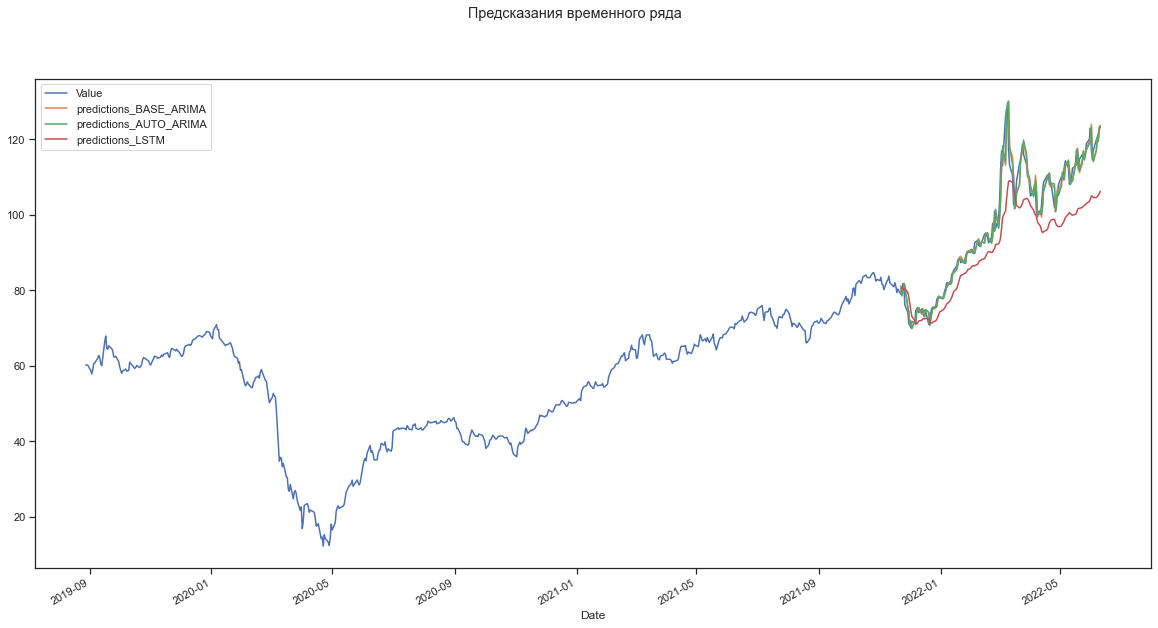

In [223]:
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(20,10))
fig.suptitle('Предсказания временного ряда')
df_sort.plot(ax=ax, legend=True)
plt.show()

### Оценка моеделей

Будем оценивать модели двумя метриками: Среднеяя абсолютная ошибка и Средняя квадратичная ошибка

In [288]:
def plot_metrics(metrics, models, test_y):
    for name, fun in metrics.items():
        fig, ax = plt.subplots(figsize=(10,10))
        results_metrics = []
        
        for nm, results in models.items():
            results_metrics.append(fun(test_y, results))
    
        sorted_el = list(sorted(list(zip(models.keys(), results_metrics)), key=lambda x: -x[1]))
        results_metrics = list(map(lambda x: x[1], sorted_el))
        model_list = list(map(lambda x: x[0], sorted_el))
        
        pos = np.arange(len(model_list))
        rects = ax.barh(pos, results_metrics,
                     align='center',
                     height=0.5, 
                     tick_label=model_list)
        ax.set_title(name)
        for a, b in zip(pos, results_metrics):
            plt.text(max(results_metrics) * 0.1, a-0.05, str(round(b,6)), color='black')
        plt.show() 

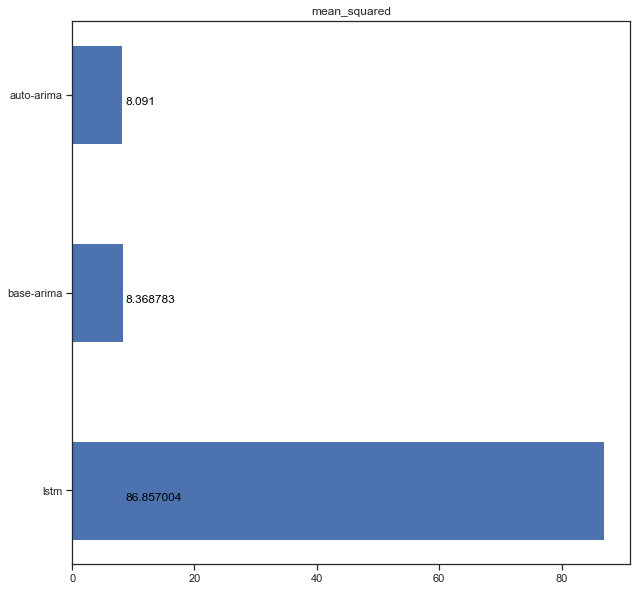

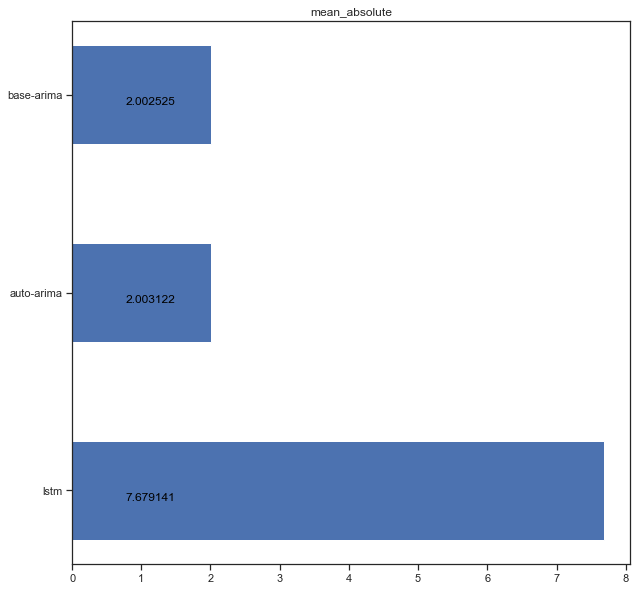

In [289]:
metrics = {
    'mean_squared':mean_squared_error,
    'mean_absolute':mean_absolute_error
}

predictions = {
    'base-arima': predictions_base_arima,
    'auto-arima': predictions_auto_arima,
    'lstm': lstm_predicts_un_normal
}

plot_metrics(metrics, predictions, test)